## Imports 

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier
from pprint import pprint
from sklearn.metrics import ConfusionMatrixDisplay


if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()
os.chdir(root)


ModuleNotFoundError: No module named 'tools.edi'

### Getting our data 

In [15]:
from tools.edi  import easy_data_import

X, y , ts_cv = easy_data_import()


ModuleNotFoundError: No module named 'tools.edi'

# 1) Random Forest 

### All the possible parameters 

In [20]:
rf = RandomForestClassifier(random_state = 42)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### Using a randomized grid search 

In [21]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Number of trees in random forest
n_estimators = [3,10,30]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,3,4,5]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [False],
 'max_depth': [2, 3, 4, 5],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]}


### Training 

In [22]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_distributions = random_grid , cv = ts_cv)
# Fit the random search model
rf_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\maria\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [2, 3, 4, 5],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140, 160, 180,
                                                         200]},
                   random_state=42, verbose=2)

### Our final model 

In [23]:
final_model = rf_random.best_estimator_

In [24]:
y_pred= final_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.75      0.68       247
           1       0.66      0.52      0.58       236

    accuracy                           0.64       483
   macro avg       0.64      0.64      0.63       483
weighted avg       0.64      0.64      0.63       483



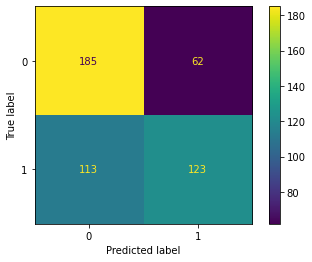

In [25]:
ConfusionMatrixDisplay.from_estimator(estimator=final_model, X=X_test, y=y_test)

# 2) Decision Tree

In [26]:
tree_clf= DecisionTreeClassifier(max_depth= 4)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

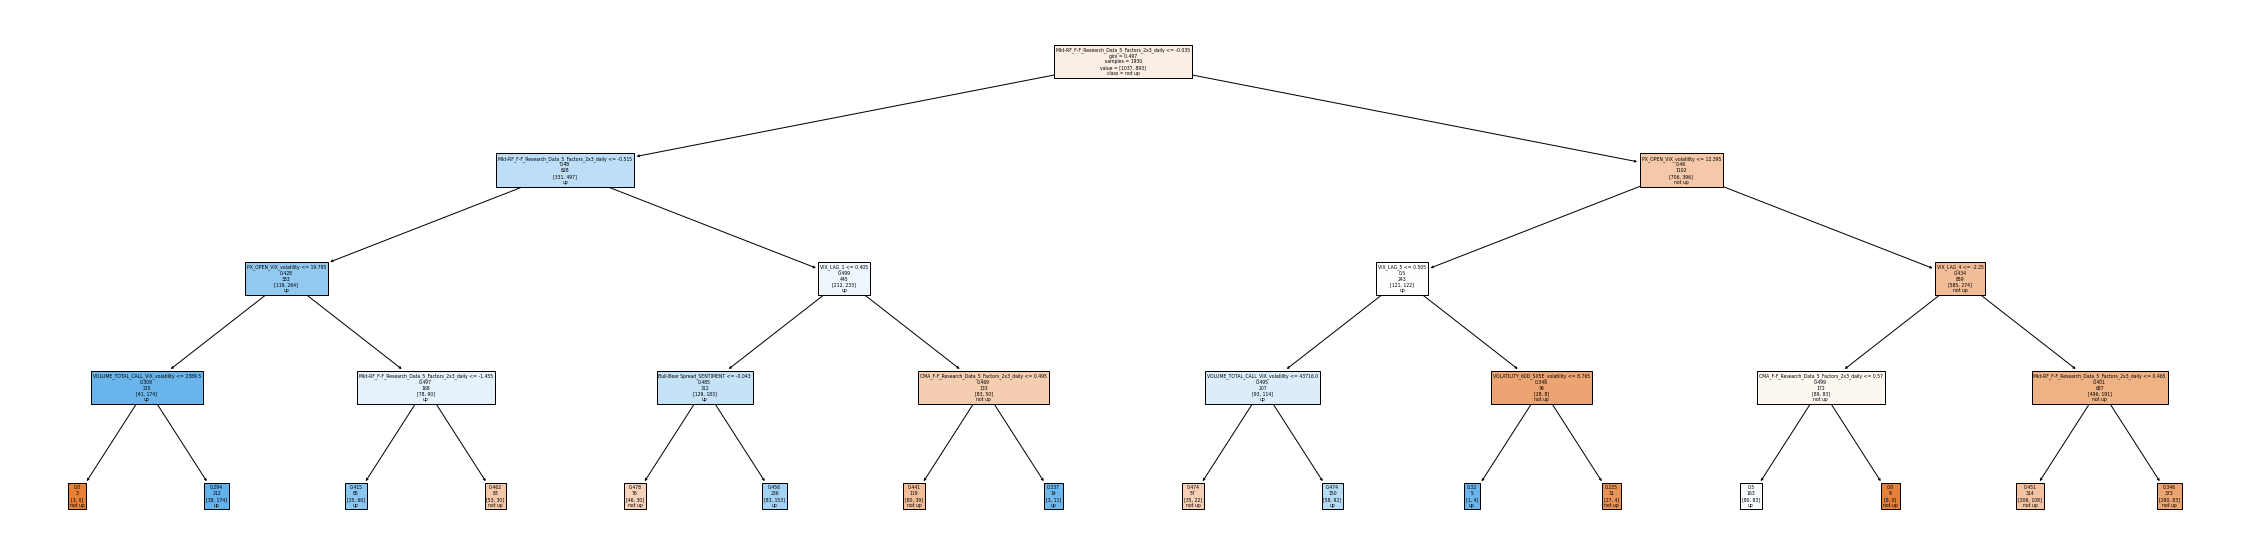

In [27]:
from sklearn import tree


fig = plt.figure(figsize=(40,10))
_ = tree.plot_tree(tree_clf, 
                   label='root',
                   feature_names= our_features,  
                   class_names= ['not up', 'up'],
                   filled=True)